In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
import numpy as np
import progressbar
import scipy.io as spio
import os
from matplotlib import pyplot as plt
%load_ext tensorboard
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
mat_train = spio.loadmat('/content/drive/My Drive/Deep1/train.mat')
mat_trainlbl = spio.loadmat('/content/drive/My Drive/Deep1/trainlbl.mat')
mat_test = spio.loadmat('/content/drive/My Drive/Deep1/test.mat')
mat_testbl = spio.loadmat('/content/drive/My Drive/Deep1/testlbl.mat')
print(sorted(mat_train.keys()))
print(sorted(mat_trainlbl.keys()))
print(sorted(mat_test.keys()))
print(sorted(mat_testbl.keys()))
x_train = np.array(mat_train['train'])
y_train = np.array(mat_trainlbl['trainlbl'])
x_test = np.array(mat_test['test'])
y_test = np.array(mat_testbl['testlbl'])
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

['__globals__', '__header__', '__version__', 'train']
['__globals__', '__header__', '__version__', 'trainlbl']
['__globals__', '__header__', '__version__', 'test']
['__globals__', '__header__', '__version__', 'testlbl']
x_train:  (400, 200, 200, 3)
y_train:  (400, 1)
x_test:  (100, 200, 200, 3)
y_test:  (100, 1)


[9]


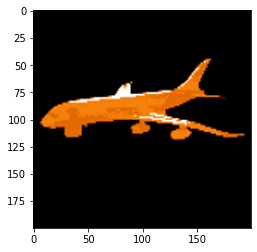

In [0]:
n =40
print(y_train[n])
plt.imshow(x_train[n])

In [0]:
def make_mini_batches(N,batch_size=64, shuffle=True):
  shuffled_ind = np.arange(N)
  Idx = []
  if shuffle:
      np.random.shuffle(shuffled_ind)
  mini_batch = []
  num_mini = N // batch_size 
  for i in range(num_mini):
      Idx.append((shuffled_ind[i*batch_size:i*batch_size + batch_size]))
  if N % batch_size:
      Idx.append((shuffled_ind[N - N%batch_size:N]))
  return Idx



class CNN:
  """Convolutional Neural Network module"""
  def __init__(self,filters,kernels, strides,pool_after, apply_dropout=False, drop_rate=0.5, regularizer=tf.keras.regularizers.l2):
    """
    args:
      filters: list of integers that presents num filters per layer
      kernels: list of integers that presents kernel size for each layer
      strides: list of integers that presents stride for each layer
      apply_dropout: bool that presents dropout after each layer
      drop_rate: The dropout rate, between 0 and 1. E.g. `rate=0.1` would drop out  
      10% of input units
      regularizer: kernel regularizer
      
    Errors:
      filters, kernels and strides must be lists
      length filters ,kernels and strides must be equal
    """
    assert isinstance(filters, list)
    assert isinstance(kernels, list)
    assert isinstance(strides, list)
    assert isinstance(pool_after, list)
    assert len(filters) == len(kernels) == len(strides)
    layers = []
    
    with tf.variable_scope('CNN'):
      for i in range(len(filters)):
        conv_layer = tf.layers.Conv2D(filters=filters[i], kernel_size=kernels[i],strides=strides[i], padding='same',activation='relu',kernel_regularizer=regularizer,name='conv-%d'%i)
        print('conv2d: filters = %d, kernel_size = (%d, %d), strides = (%d, %d)'%(filters[i], kernels[i],kernels[i], strides[i],strides[i] ))
        layers.append(conv_layer)
        if apply_dropout:
          drop_layer = tf.layers.Dropout(rate=drop_rate)
          print('dropout: drop_rate = %2.2f'%(drop_rate))
          layers.append(drop_layer)
        if i+1 in set(pool_after):
          pool_layer = tf.layers.MaxPooling2D(pool_size=3,strides=2)
          print('maxpool: pool_size = (3,3), strides=(2,2)')
          layers.append(pool_layer)

      self.layers = layers
    

  def __call__(self,x, is_training=False):
    """
    call CNN module,
    args:
      x: input with shape(N,H,W,C)
      is_training: train dropout layer(in case of dropout)
    returns:
      output of network
    """
    feature_maps = []
    for op in self.layers:
      if isinstance(op,tf.layers.Dropout):
        x = op(x, is_training)
      else:
        x = op(x)
        feature_maps.append(x)
    return x, feature_maps

class FCNN:
  """Fully Connected Neural Network module"""
  def __init__(self,units, apply_dropout=False, drop_rate=0.5, regularizer=tf.keras.regularizers.l2):
    """
    args:
      units: list of integers that presents num units per layer
      apply_dropout: bool that presents dropout after each layer
      drop_rate: The dropout rate, between 0 and 1. E.g. `rate=0.1` would drop out  
      10% of input units
      regularizer: kernel regularizer
      
    Errors:
      units must be list
    """
    assert isinstance(units, list)
    layers = []
    with tf.variable_scope('FC'):
      for i in range(len(units)):
        dense_layer = tf.layers.Dense(units=units[i], activation='relu',kernel_regularizer=regularizer)
        print('fc: units = %d'%( units[i]))
        layers.append(dense_layer)
        if apply_dropout and i<len(units)-1:
          drop_layer = tf.layers.Dropout(rate=drop_rate)
          print('dropout: drop_rate = %2.2f '%(drop_rate))
          layers.append(drop_layer)
      
      self.layers = layers
  def __call__(self,x, is_training=False):
    """
    call FCNN module,
    args:
      x: input with shape(N,M)
      is_training: train dropout layer(in case of dropout)
    returns:
      output of network
    """
    for op in self.layers:
      if isinstance(op,tf.layers.Dense):
        x = op(x)
      else:
        x = op(x, is_training)
    return x
   
    
    
    
    

In [0]:
class classifier:
  """
  classifier module
  """
  def __init__(self, params):
    """
    args:
      params: dictionary for model architecture
            .conv_filters: list of convolutional filters per layer
            .conv_kernels: list of convolutional kernel size per layer
            .conv_strides: list of convolutional stride per layer
            .conv_dropout: bool that indicates dropout after each conv layer
            .dropout_rate:  The dropout rate, between 0 and 1.
            .dense_layers: list of fc units per layer after conv_layers
            .dense_dropout: bool that indicates dropout after fc layers
            .regularizer: regularization function
            .num_classes: number of classes for output
            
    """
    self.params = params
    print('\n########################')
    print('Model summary: ')
    self.cnn_model = CNN(filters=params['conv_filters'],kernels=params['conv_kernels'], strides=params['conv_strides'],pool_after=params['pool_after'], apply_dropout=params['conv_dropout'], drop_rate=params['dropout_rate'], regularizer=params['regularizer'])
    if len(params['conv_filters']):
      print('- global average pool')
      self.pool = tf.keras.layers.GlobalAveragePooling2D()
    else:
      print('- flatten')
      self.pool = tf.keras.layers.Flatten()
    self.fc_model = FCNN(params['dense_layers'],apply_dropout=params['dense_dropout'],drop_rate=params['dropout_rate'],regularizer=params['regularizer'])
    print('output_layer fc: units = ', params['num_classes'])
    print()
    self.out_layer = tf.layers.Dense(units=params['num_classes'],activation=None)
    
  def __call__(self, x, is_training=False):
    cnn_output, feature_maps = self.cnn_model(x, is_training)
    pool = self.pool(cnn_output)
    fc_output = self.fc_model(pool, is_training)
    output_logits = self.out_layer(fc_output)
    return output_logits, feature_maps
  def compute_loss(self,y_true,output_logits):
    true_one_hot = tf.one_hot(y_true,self.params['num_classes'])
    softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=true_one_hot, logits=output_logits, axis=1))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_losses = tf.reduce_sum(reg_losses)
    return softmax_loss, reg_losses
  def compute_accuracy(self,y_true, output_logits):
    y_pred = tf.math.argmax(output_logits, axis=1, name="y_prediction")
    TP = tf.cast(tf.math.equal(y_pred, y_true), tf.float32)
    acc = tf.reduce_mean(TP, name="accuracy")
    return acc

In [136]:
tf.reset_default_graph()
############################# Tensorboard Summaries ##################################
with tf.name_scope("Accuracy"):
  train_acc = tf.placeholder(name="train_acc", dtype=tf.float32)
  tr_summary_acc = tf.summary.scalar("train_accuracy", train_acc)
  val_acc = tf.placeholder(name="val_acc", dtype=tf.float32)
  val_summary_acc = tf.summary.scalar("validation_accuracy", val_acc)
accuracy_sumarry = tf.summary.merge([tr_summary_acc, val_summary_acc])
# loss summary:
with tf.name_scope("Losses"):
  train_softmax_loss = tf.placeholder(name="train_softmax_loss", dtype=tf.float32)
  tr_summary_softmax_loss = tf.summary.scalar("train_softmax_loss", train_softmax_loss)
  train_reg_loss = tf.placeholder(name="train_reg_loss", dtype=tf.float32)
  tr_summary_reg_loss = tf.summary.scalar("train_reg_loss", train_reg_loss)
  total_train_loss = train_reg_loss + train_softmax_loss
  tr_summary_loss = tf.summary.scalar("train_loss", total_train_loss)

  val_softmax_loss = tf.placeholder(name="val_softmax_loss", dtype=tf.float32)
  val_summary_softmax_loss = tf.summary.scalar("val_softmax_loss", val_softmax_loss)
  val_reg_loss = tf.placeholder(name="val_reg_loss", dtype=tf.float32)
  val_summary_reg_loss = tf.summary.scalar("val_reg_loss", val_reg_loss)
  total_val_loss = val_reg_loss + val_softmax_loss
  val_summary_loss = tf.summary.scalar("val_loss", total_val_loss)
loss_summary = tf.summary.merge([tr_summary_softmax_loss, tr_summary_reg_loss,tr_summary_loss, val_summary_softmax_loss, val_summary_reg_loss, val_summary_loss])
################################################################################

######################## training ##############################################
input_tensor = tf.placeholder(dtype=tf.float32, shape=[None, x_train.shape[1],x_train.shape[2],3], name='input_tensor')
model_input = (input_tensor - tf.reduce_min(input_tensor, axis=0))/(tf.reduce_max(input_tensor, axis=0) - tf.reduce_min(input_tensor, axis=0)+1e-5)# normalize
#model_input = tf.expand_dims(model_input, axis=-1)
true_labels = tf.placeholder(dtype=tf.int64, shape=(None), name='true_labels')
is_training = tf.placeholder_with_default(False, shape=(),name='is_training')
reg = 1e-1
model_name = 'reg=%g'%reg
params = {'conv_filters':[16,16,32,32,64,64],
          'conv_kernels':[3,3,5,5,7,7],
          'pool_after':[2,4],
          'conv_strides':[1,1,1,1,1,1],
          'conv_dropout':False,
          'dense_layers':[],
          'dense_dropout':False,
          'dropout_rate':0.2,
          'regularizer':tf.keras.regularizers.l2(),
          'num_classes':10,
          'reg_loss':reg,
          'epochs':30,
          'batch_size':16,
          'initial_lr':1e-3,
          'lr_decay_step':1000,
          'lr_decay_factor':1.
          }

model = classifier(params)
output_logits, feature_maps = model(model_input, is_training)
softmax_loss, reg_loss = model.compute_loss(true_labels, output_logits)
reg_loss = params['reg_loss'] * reg_loss
total_loss  = softmax_loss + reg_loss
accuracy = model.compute_accuracy(true_labels, output_logits)
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(params['initial_lr'],
                                global_step, params['lr_decay_step'],params['lr_decay_factor'], staircase=True, name='exponential_learning_rate')
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(total_loss)
init_op = tf.global_variables_initializer()
saver_to_restore = tf.train.Saver(tf.global_variables())
saver = tf.train.Saver(max_to_keep=1)
save_path = 'saved_model'
restore_path = ''
Evaluate_Train = True
os.system('mkdir {}'.format(save_path))
sess = tf.InteractiveSession()# open session
sum_writer = tf.summary.FileWriter(model_name, sess.graph)
sess.run(init_op) # initialize all variables
if False: #restore model
  saver_to_restore.restore(sess, restore_path)
max_val_acc = 0.2
predictions = []
for itr in range(params['epochs']):
  ###First evaluate:
  tr_total_loss = 0
  tr_reg_loss = 0
  tr_softmax_loss = 0
  tr_acc = 0
  if Evaluate_Train: #evaluate train data
    batch_indices = make_mini_batches(x_train.shape[0], params['batch_size'])
    N = len(batch_indices)
    for idx in batch_indices:
      x_mini = x_train[idx]
      y_mini = y_train[idx].reshape(-1)
      train_batch_softmax_loss,train_batch_reg_loss, train_batch_loss, train_batch_acc = sess.run([softmax_loss, reg_loss, total_loss, accuracy], feed_dict={input_tensor:x_mini, true_labels:y_mini, is_training:False})
      tr_total_loss += train_batch_loss/N
      tr_reg_loss += train_batch_reg_loss/N
      tr_softmax_loss += train_batch_softmax_loss/N
      tr_acc += train_batch_acc/N
    
  
  _val_total_loss = 0
  _val_reg_loss = 0
  _val_softmax_loss = 0
  _val_acc = 0
  
  if True: #evaluate test data
    batch_indices = make_mini_batches(x_test.shape[0], params['batch_size'])
    N = len(batch_indices)
    for idx in batch_indices:
      x_mini = x_test[idx]
      y_mini = y_test[idx].reshape(-1)
      val_batch_softmax_loss,val_batch_reg_loss, val_batch_loss, val_batch_acc = sess.run([softmax_loss, reg_loss, total_loss, accuracy], feed_dict={input_tensor:x_mini, true_labels:y_mini, is_training:False})
      _val_total_loss += val_batch_loss/N
      _val_reg_loss += val_batch_reg_loss/N
      _val_softmax_loss += val_batch_softmax_loss/N
      _val_acc += val_batch_acc/N
  _acc_sum, _loss_sum = sess.run([accuracy_sumarry,loss_summary], feed_dict={train_acc:tr_acc, val_acc:_val_acc,
                                                                             train_softmax_loss:tr_softmax_loss, train_reg_loss:tr_reg_loss,
                                                                             val_softmax_loss:_val_softmax_loss, val_reg_loss:_val_reg_loss
                                                                             })
  val_batch_output_logits = sess.run(output_logits, feed_dict={input_tensor:x_mini, true_labels:y_mini, is_training:False})
  sum_writer.add_summary(_acc_sum, itr)
  sum_writer.add_summary(_loss_sum, itr)
  if max_val_acc<_val_acc:# save best model
    max_val_acc = _val_acc
    saver.save(sess, save_path+'/accuracy-%2.4f'%max_val_acc+'.ckpt' )
    predictions = np.argmax(val_batch_output_logits, axis=-1)
    print('\n')
    print(predictions)
  
  if True:
    print()
    print('Epoch ',itr)
    print('Train. Loss=%2.4f, softmax_loss=%2.4f, reg_loss=%2.4f, accuracy=%2.4f'%(tr_total_loss, tr_softmax_loss, tr_reg_loss, tr_acc))
    print('Test.  Loss=%2.4f, softmax_loss=%2.4f, reg_loss=%2.4f, accuracy=%2.4f'%(_val_total_loss, _val_softmax_loss, _val_reg_loss, _val_acc))
    print()

  ##Now train:
  batch_indices = make_mini_batches(x_train.shape[0], params['batch_size'])
 
  bar =  progressbar.ProgressBar(maxval=len(batch_indices),
                                widgets=[progressbar.Bar('*', '[', ']'),' ',progressbar.Percentage()])
  bar.start()
  tr_total_loss = 0
  tr_reg_loss = 0
  tr_softmax_loss = 0
  tr_acc = 0
  N = len(batch_indices)
  for i,idx in enumerate(batch_indices):
    bar.update(i)
    x_mini = x_train[idx]
    y_mini = y_train[idx].reshape(-1)
    ## apply augmentation here
    _global_step, train_batch_softmax_loss,train_batch_reg_loss, train_batch_loss, train_batch_acc, _ = sess.run([global_step, softmax_loss, reg_loss, total_loss, accuracy, train_op], feed_dict={input_tensor:x_mini, true_labels:y_mini, is_training:True})
    tr_total_loss += train_batch_loss/N
    tr_reg_loss += train_batch_reg_loss/N
    tr_softmax_loss += train_batch_softmax_loss/N
    tr_acc += train_batch_acc/N
  bar.finish()
  print('Running summary: ')
  print('Train. Loss=%2.4f, softmax_loss=%2.4f, reg_loss=%2.4f, accuracy=%2.4f'%(tr_total_loss, tr_softmax_loss, tr_reg_loss, tr_acc))
  print()
  


########################
Model summary: 
conv2d: filters = 16, kernel_size = (3, 3), strides = (1, 1)
conv2d: filters = 16, kernel_size = (3, 3), strides = (1, 1)
maxpool: pool_size = (3,3), strides=(2,2)
conv2d: filters = 32, kernel_size = (5, 5), strides = (1, 1)
conv2d: filters = 32, kernel_size = (5, 5), strides = (1, 1)
maxpool: pool_size = (3,3), strides=(2,2)
conv2d: filters = 64, kernel_size = (7, 7), strides = (1, 1)
conv2d: filters = 64, kernel_size = (7, 7), strides = (1, 1)
- global average pool
output_layer fc: units =  10



/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
[                                                                        ] N/A%


Epoch  0
Train. Loss=2.4817, softmax_loss=2.3006, reg_loss=0.1810, accuracy=0.1000
Test.  Loss=2.4813, softmax_loss=2.3003, reg_loss=0.1810, accuracy=0.0893



[************************************************************************] 100%


Running summary: 
Train. Loss=2.4443, softmax_loss=2.3144, reg_loss=0.1299, accuracy=0.1050



[                                                                        ] N/A%


Epoch  1
Train. Loss=2.3818, softmax_loss=2.2898, reg_loss=0.0920, accuracy=0.1000
Test.  Loss=2.3883, softmax_loss=2.2963, reg_loss=0.0920, accuracy=0.0893



[************************************************************************] 100%


Running summary: 
Train. Loss=2.3563, softmax_loss=2.2790, reg_loss=0.0773, accuracy=0.0850



[                                                                        ] N/A%


Epoch  2
Train. Loss=2.3154, softmax_loss=2.2491, reg_loss=0.0662, accuracy=0.1150
Test.  Loss=2.2947, softmax_loss=2.2285, reg_loss=0.0662, accuracy=0.1339



[************************************************************************] 100%


Running summary: 
Train. Loss=2.2403, softmax_loss=2.1790, reg_loss=0.0612, accuracy=0.1200



[                                                                        ] N/A%


Epoch  3
Train. Loss=2.0603, softmax_loss=2.0028, reg_loss=0.0575, accuracy=0.1975
Test.  Loss=2.0932, softmax_loss=2.0356, reg_loss=0.0575, accuracy=0.1696



[************************************************************************] 100%


Running summary: 
Train. Loss=2.0435, softmax_loss=1.9883, reg_loss=0.0553, accuracy=0.2350



[                                                                        ] N/A%



[8 8 4 7]

Epoch  4
Train. Loss=2.1416, softmax_loss=2.0885, reg_loss=0.0532, accuracy=0.1900
Test.  Loss=2.1580, softmax_loss=2.1048, reg_loss=0.0532, accuracy=0.2054



[************************************************************************] 100%


Running summary: 
Train. Loss=1.9811, softmax_loss=1.9294, reg_loss=0.0517, accuracy=0.2675



[                                                                        ] N/A%



[0 2 0 6]

Epoch  5
Train. Loss=1.8547, softmax_loss=1.8045, reg_loss=0.0502, accuracy=0.2925
Test.  Loss=1.8816, softmax_loss=1.8314, reg_loss=0.0502, accuracy=0.2857



[************************************************************************] 100%


Running summary: 
Train. Loss=1.8721, softmax_loss=1.8230, reg_loss=0.0491, accuracy=0.2825



[                                                                        ] N/A%


Epoch  6
Train. Loss=1.8411, softmax_loss=1.7932, reg_loss=0.0479, accuracy=0.2875
Test.  Loss=1.8464, softmax_loss=1.7984, reg_loss=0.0479, accuracy=0.2857



[************************************************************************] 100%


Running summary: 
Train. Loss=1.8369, softmax_loss=1.7899, reg_loss=0.0470, accuracy=0.3100



[                                                                        ] N/A%



[0 8 0 0]

Epoch  7
Train. Loss=1.8723, softmax_loss=1.8262, reg_loss=0.0460, accuracy=0.2625
Test.  Loss=1.8413, softmax_loss=1.7953, reg_loss=0.0460, accuracy=0.3036



[************************************************************************] 100%


Running summary: 
Train. Loss=1.7779, softmax_loss=1.7324, reg_loss=0.0455, accuracy=0.2950



[                                                                        ] N/A%



[1 7 8 5]

Epoch  8
Train. Loss=1.7050, softmax_loss=1.6604, reg_loss=0.0446, accuracy=0.3075
Test.  Loss=1.7360, softmax_loss=1.6914, reg_loss=0.0446, accuracy=0.3393



[************************************************************************] 100%


Running summary: 
Train. Loss=1.6966, softmax_loss=1.6528, reg_loss=0.0439, accuracy=0.3325



[                                                                        ] N/A%



[0 0 2 5]

Epoch  9
Train. Loss=1.6188, softmax_loss=1.5755, reg_loss=0.0433, accuracy=0.3825
Test.  Loss=1.5168, softmax_loss=1.4735, reg_loss=0.0433, accuracy=0.4018



[************************************************************************] 100%


Running summary: 
Train. Loss=1.6538, softmax_loss=1.6106, reg_loss=0.0432, accuracy=0.3150



[                                                                        ] N/A%


Epoch  10
Train. Loss=1.6382, softmax_loss=1.5949, reg_loss=0.0433, accuracy=0.3500
Test.  Loss=1.5887, softmax_loss=1.5454, reg_loss=0.0433, accuracy=0.3750



[************************************************************************] 100%


Running summary: 
Train. Loss=1.6825, softmax_loss=1.6392, reg_loss=0.0433, accuracy=0.3275



[                                                                        ] N/A%


Epoch  11
Train. Loss=1.6052, softmax_loss=1.5616, reg_loss=0.0435, accuracy=0.3725
Test.  Loss=1.5587, softmax_loss=1.5152, reg_loss=0.0435, accuracy=0.3750



[************************************************************************] 100%


Running summary: 
Train. Loss=1.5588, softmax_loss=1.5152, reg_loss=0.0436, accuracy=0.4000



[                                                                        ] N/A%


Epoch  12
Train. Loss=1.4844, softmax_loss=1.4403, reg_loss=0.0441, accuracy=0.3975
Test.  Loss=1.4262, softmax_loss=1.3821, reg_loss=0.0441, accuracy=0.3571



[************************************************************************] 100%


Running summary: 
Train. Loss=1.5173, softmax_loss=1.4727, reg_loss=0.0446, accuracy=0.3875



[                                                                        ] N/A%



[7 0 2 8]

Epoch  13
Train. Loss=1.5221, softmax_loss=1.4768, reg_loss=0.0453, accuracy=0.3900
Test.  Loss=1.4224, softmax_loss=1.3771, reg_loss=0.0453, accuracy=0.4375



[************************************************************************] 100%


Running summary: 
Train. Loss=1.4551, softmax_loss=1.4092, reg_loss=0.0459, accuracy=0.4275



[                                                                        ] N/A%



[2 9 8 5]

Epoch  14
Train. Loss=1.3127, softmax_loss=1.2659, reg_loss=0.0468, accuracy=0.5500
Test.  Loss=1.1823, softmax_loss=1.1355, reg_loss=0.0468, accuracy=0.6071



[************************************************************************] 100%


Running summary: 
Train. Loss=1.4154, softmax_loss=1.3674, reg_loss=0.0480, accuracy=0.4675



[                                                                        ] N/A%


Epoch  15
Train. Loss=1.3932, softmax_loss=1.3439, reg_loss=0.0492, accuracy=0.4025
Test.  Loss=1.2887, softmax_loss=1.2395, reg_loss=0.0492, accuracy=0.4643



[************************************************************************] 100%


Running summary: 
Train. Loss=1.3715, softmax_loss=1.3212, reg_loss=0.0503, accuracy=0.4600



[                                                                        ] N/A%


Epoch  16
Train. Loss=1.2758, softmax_loss=1.2242, reg_loss=0.0516, accuracy=0.5275
Test.  Loss=1.3008, softmax_loss=1.2492, reg_loss=0.0516, accuracy=0.4911



[************************************************************************] 100%


Running summary: 
Train. Loss=1.4005, softmax_loss=1.3472, reg_loss=0.0533, accuracy=0.5100



[                                                                        ] N/A%


Epoch  17
Train. Loss=1.3524, softmax_loss=1.2970, reg_loss=0.0553, accuracy=0.4925
Test.  Loss=1.2776, softmax_loss=1.2222, reg_loss=0.0553, accuracy=0.5357



[************************************************************************] 100%


Running summary: 
Train. Loss=1.1980, softmax_loss=1.1406, reg_loss=0.0573, accuracy=0.5850



[                                                                        ] N/A%


Epoch  18
Train. Loss=1.1579, softmax_loss=1.0983, reg_loss=0.0596, accuracy=0.5825
Test.  Loss=1.0477, softmax_loss=0.9881, reg_loss=0.0596, accuracy=0.5804



[************************************************************************] 100%


Running summary: 
Train. Loss=1.1008, softmax_loss=1.0394, reg_loss=0.0614, accuracy=0.6225



[                                                                        ] N/A%



[0 9 8 9]

Epoch  19
Train. Loss=0.9774, softmax_loss=0.9138, reg_loss=0.0636, accuracy=0.6675
Test.  Loss=1.0033, softmax_loss=0.9397, reg_loss=0.0636, accuracy=0.6250



[************************************************************************] 100%


Running summary: 
Train. Loss=1.1397, softmax_loss=1.0737, reg_loss=0.0660, accuracy=0.6200



[                                                                        ] N/A%


Epoch  20
Train. Loss=1.2591, softmax_loss=1.1906, reg_loss=0.0685, accuracy=0.5575
Test.  Loss=1.2384, softmax_loss=1.1698, reg_loss=0.0685, accuracy=0.5625



[************************************************************************] 100%


Running summary: 
Train. Loss=0.9889, softmax_loss=0.9187, reg_loss=0.0702, accuracy=0.6775



[                                                                        ] N/A%


Epoch  21
Train. Loss=1.1854, softmax_loss=1.1135, reg_loss=0.0720, accuracy=0.6000
Test.  Loss=1.3660, softmax_loss=1.2940, reg_loss=0.0720, accuracy=0.5446



[************************************************************************] 100%


Running summary: 
Train. Loss=0.8978, softmax_loss=0.8243, reg_loss=0.0735, accuracy=0.6900



[                                                                        ] N/A%



[8 3 0 8]

Epoch  22
Train. Loss=0.7014, softmax_loss=0.6262, reg_loss=0.0752, accuracy=0.8200
Test.  Loss=0.9277, softmax_loss=0.8525, reg_loss=0.0752, accuracy=0.7143



[************************************************************************] 100%


Running summary: 
Train. Loss=0.8109, softmax_loss=0.7344, reg_loss=0.0765, accuracy=0.7375



[                                                                        ] N/A%


Epoch  23
Train. Loss=0.8679, softmax_loss=0.7898, reg_loss=0.0781, accuracy=0.6775
Test.  Loss=1.5179, softmax_loss=1.4399, reg_loss=0.0781, accuracy=0.5714



[************************************************************************] 100%


Running summary: 
Train. Loss=0.8005, softmax_loss=0.7212, reg_loss=0.0793, accuracy=0.7300



[                                                                        ] N/A%


Epoch  24
Train. Loss=0.7430, softmax_loss=0.6626, reg_loss=0.0804, accuracy=0.7250
Test.  Loss=0.9029, softmax_loss=0.8225, reg_loss=0.0804, accuracy=0.6518



[************************************************************************] 100%


Running summary: 
Train. Loss=0.6829, softmax_loss=0.6015, reg_loss=0.0814, accuracy=0.7800



[                                                                        ] N/A%


Epoch  25
Train. Loss=0.7709, softmax_loss=0.6887, reg_loss=0.0822, accuracy=0.7725
Test.  Loss=2.4165, softmax_loss=2.3343, reg_loss=0.0822, accuracy=0.6161



[************************************************************************] 100%


Running summary: 
Train. Loss=0.7490, softmax_loss=0.6661, reg_loss=0.0829, accuracy=0.7700



[                                                                        ] N/A%


Epoch  26
Train. Loss=0.8385, softmax_loss=0.7544, reg_loss=0.0842, accuracy=0.7075
Test.  Loss=1.5566, softmax_loss=1.4724, reg_loss=0.0842, accuracy=0.6161



[************************************************************************] 100%


Running summary: 
Train. Loss=0.7831, softmax_loss=0.6976, reg_loss=0.0855, accuracy=0.7350



[                                                                        ] N/A%



[9 4 3 8]

Epoch  27
Train. Loss=0.6141, softmax_loss=0.5269, reg_loss=0.0872, accuracy=0.8325
Test.  Loss=0.7252, softmax_loss=0.6380, reg_loss=0.0872, accuracy=0.8036



[************************************************************************] 100%


Running summary: 
Train. Loss=0.6142, softmax_loss=0.5256, reg_loss=0.0885, accuracy=0.8350



[                                                                        ] N/A%


Epoch  28
Train. Loss=0.5084, softmax_loss=0.4191, reg_loss=0.0893, accuracy=0.8550
Test.  Loss=1.0820, softmax_loss=0.9928, reg_loss=0.0893, accuracy=0.7768



[************************************************************************] 100%


Running summary: 
Train. Loss=0.6080, softmax_loss=0.5181, reg_loss=0.0899, accuracy=0.8275



[                                                                        ] N/A%


Epoch  29
Train. Loss=0.5171, softmax_loss=0.4261, reg_loss=0.0909, accuracy=0.8675
Test.  Loss=1.1235, softmax_loss=1.0325, reg_loss=0.0909, accuracy=0.7500



[************************************************************************] 100%


Running summary: 
Train. Loss=0.5746, softmax_loss=0.4829, reg_loss=0.0917, accuracy=0.8350



In [137]:
feature_maps

[<tf.Tensor 'conv-0/Relu:0' shape=(?, 200, 200, 16) dtype=float32>,
 <tf.Tensor 'conv-1/Relu:0' shape=(?, 200, 200, 16) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 99, 99, 16) dtype=float32>,
 <tf.Tensor 'conv-2/Relu:0' shape=(?, 99, 99, 32) dtype=float32>,
 <tf.Tensor 'conv-3/Relu:0' shape=(?, 99, 99, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 49, 49, 32) dtype=float32>,
 <tf.Tensor 'conv-4/Relu:0' shape=(?, 49, 49, 64) dtype=float32>,
 <tf.Tensor 'conv-5/Relu:0' shape=(?, 49, 49, 64) dtype=float32>]

In [0]:
# close session
sess.close()

In [140]:
# run tensorboard in current directory
%tensorboard --logdir=.

Reusing TensorBoard on port 6006 (pid 13843), started 0:00:34 ago. (Use '!kill 13843' to kill it.)

In [122]:
# test saved model:

restore_path = '/content/saved_model/accuracy-0.8750.ckpt'
tf.reset_default_graph()
#imported_meta = tf.train.import_meta_graph('/content/saved_model/accuracy-0.8750.ckpt.meta')

input_tensor = tf.placeholder(dtype=tf.float32, shape=[None, x_train.shape[1],x_train.shape[2], x_train.shape[3]], name='input_tensor')
model_input = input_tensor#(input_tensor - tf.reduce_min(input_tensor, axis=0))/(tf.reduce_max(input_tensor, axis=0) - tf.reduce_min(input_tensor, axis=0)) # normalize
true_labels = tf.placeholder(dtype=tf.int64, shape=(None), name='true_labels')
is_training = tf.placeholder_with_default(False, shape=(),name='is_training')
reg = 1e-1
model_name = 'model1'
params = {'conv_filters':[16,16,32,32,64,64],
          'conv_kernels':[3,3,5,5,7,7],
          'pool_after':[2,4],
          'conv_strides':[1,1,1,1,1,1],
          'conv_dropout':False,
          'dense_layers':[],
          'dense_dropout':False,
          'dropout_rate':0.2,
          'regularizer':tf.keras.regularizers.l2(),
          'num_classes':10,
          'reg_loss':reg,
          'epochs':30,
          'batch_size':16,
          'initial_lr':1e-3,
          'lr_decay_step':1000,
          'lr_decay_factor':1.
          }

model = classifier(params)
output_logits, feature_maps = model(model_input, is_training)
softmax_loss, reg_loss = model.compute_loss(true_labels, output_logits)
reg_loss = params['reg_loss'] * reg_loss
total_loss  = softmax_loss + reg_loss
accuracy = model.compute_accuracy(true_labels, output_logits)

init_op = tf.global_variables_initializer()
saver_to_restore = tf.train.Saver(tf.global_variables())

sess = tf.InteractiveSession()# open session
sess.run(init_op) # initialize all variables
#sess.run(tf.initialize_all_variables())
predictions = []
_val_total_loss = 0
_val_reg_loss = 0
_val_softmax_loss = 0
_val_acc = 0
if True: #restore model
  print('restoring the model')
  saver_to_restore.restore(sess, restore_path)
k = 0
x_mini = x_test[k:k+16]
y_mini = y_test[k:k+16].reshape(-1)
print(y_mini)
val_batch_output_logits, val_batch_softmax_loss,val_batch_reg_loss, val_batch_loss, val_batch_acc = sess.run([output_logits,softmax_loss, reg_loss, total_loss, accuracy], feed_dict={input_tensor:x_mini, true_labels:y_mini, is_training:False})
predictions = np.argmax(val_batch_output_logits, axis=-1)



########################
Model summary: 
conv2d: filters = 16, kernel_size = (3, 3), strides = (1, 1)
conv2d: filters = 16, kernel_size = (3, 3), strides = (1, 1)
maxpool: pool_size = (3,3), strides=(2,2)
conv2d: filters = 32, kernel_size = (5, 5), strides = (1, 1)
conv2d: filters = 32, kernel_size = (5, 5), strides = (1, 1)
maxpool: pool_size = (3,3), strides=(2,2)
conv2d: filters = 64, kernel_size = (7, 7), strides = (1, 1)
conv2d: filters = 64, kernel_size = (7, 7), strides = (1, 1)
- global average pool
output_layer fc: units =  10

restoring the model
INFO:tensorflow:Restoring parameters from /content/saved_model/accuracy-0.8750.ckpt


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[9 4 8 0 6 1 1 0 7 1 3 2 7 3 6 6]


predicted minibatch labels [9 4 8 1 6 1 1 1 7 1 3 2 7 3 6 1]
predicted minibatch labels [9 4 8 0 6 1 1 0 7 1 3 2 7 3 6 6]
true label:  [3]
predicted label:  3


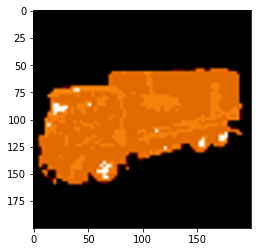

In [133]:
print('predicted minibatch labels',predictions)
print('predicted minibatch labels', y_mini)

n = 10
plt.imshow(x_test[n])
print('true label: ', y_test[n])
print('predicted label: ', predictions[n])

In [0]:
# close session
sess.close()

In [0]:
!rm -r /content/bs*

In [0]:
!kill 1164